## ISMRM 2021 Software Demo: 
## Nonlinear Model-based Reconstruction for Quantitative MRI with BART

This tutorial uses the BART command-line inteface (CLI) (http://mrirecon.github.io/bart/) and presents how to perform nonlinear model-based reconstruction for quantitative MRI (T1 mapping, water-fat separation) using BART.

**Main Reference**

Wang X, Tan Z, Scholand N, Roeloffs V, Uecker M. [Physics-based Reconstruction Methods for Magnetic Resonance Imaging](https://arxiv.org/abs/2010.01403) Philosophical Transactions of the Royal Society A, 2021.

**Authors**: [Xiaoqing Wang](mailto:xiaoqing.wang@med.uni-goettingen.de); [Zhengguo Tan](mailto:zhengguo.tan@med.uni-goettingen.de); [Nick Scholand](mailto:nick.scholand@med.uni-goettingen.de); [Holme Christian](mailto:christian.holme@med.uni-goettingen.de).

**Institution**: University Medical Center Göttingen

### 0. Setup BART

#### 0.1 Google colab

In [10]:
%%bash
## Check GPU Hardware

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Install CUDA-10.1 if not already installed
    apt-get install cuda-10-1 cuda-drivers &> /dev/null

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda

else
    echo "GPU Information:"
    nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
    nvcc --version
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi

GPU Type:
Tesla V100-SXM2-32GB Tesla V100-SXM2-32GB Tesla V100-SXM2-32GB Tesla V100-SXM2-32GB
GPU Information:
name, driver_version, memory.total [MiB]
Tesla V100-SXM2-32GB, 418.152.00, 32480 MiB
Tesla V100-SXM2-32GB, 418.152.00, 32480 MiB
Tesla V100-SXM2-32GB, 418.152.00, 32480 MiB
Tesla V100-SXM2-32GB, 418.152.00, 32480 MiB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148
Current GPU supports default CUDA-11.
No further actions are necessary.


In [ ]:
import os

# Set Library path for current CUDA version
os.environ['LD_LIBRARY_PATH'] = "/usr/local/cuda/lib64"

In [ ]:
%%bash
## Install BART

# Install BARTs dependencies

apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

In [ ]:
%%bash

# Download BART version

[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart

[ -d "bart" ] && echo "BART branch ${BRANCH} was downloaded successfully."

In [ ]:
%%bash

cd bart

# Switch to desired branch of the BART project
BRANCH="master"
git checkout $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=4
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART with CUDA
make &> /dev/null

cd ..

In [ ]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

#### 0.2 Local machine

In [1]:
import os

os.environ["TOOLBOX_PATH"] = "/home/xwang/bart"
os.environ["PATH"] = os.getenv("TOOLBOX_PATH") + os.pathsep + os.getenv("PATH")

! echo "# The BART used in this notebook:"
! which bart
! echo "# BART version: "
! bart version

# The BART used in this notebook:
/home/xwang/bart/bart
# BART version: 
v0.7.00


### 1. Introduction
#### 1.1 Inversion-prepared T1 mapping (single-shot)

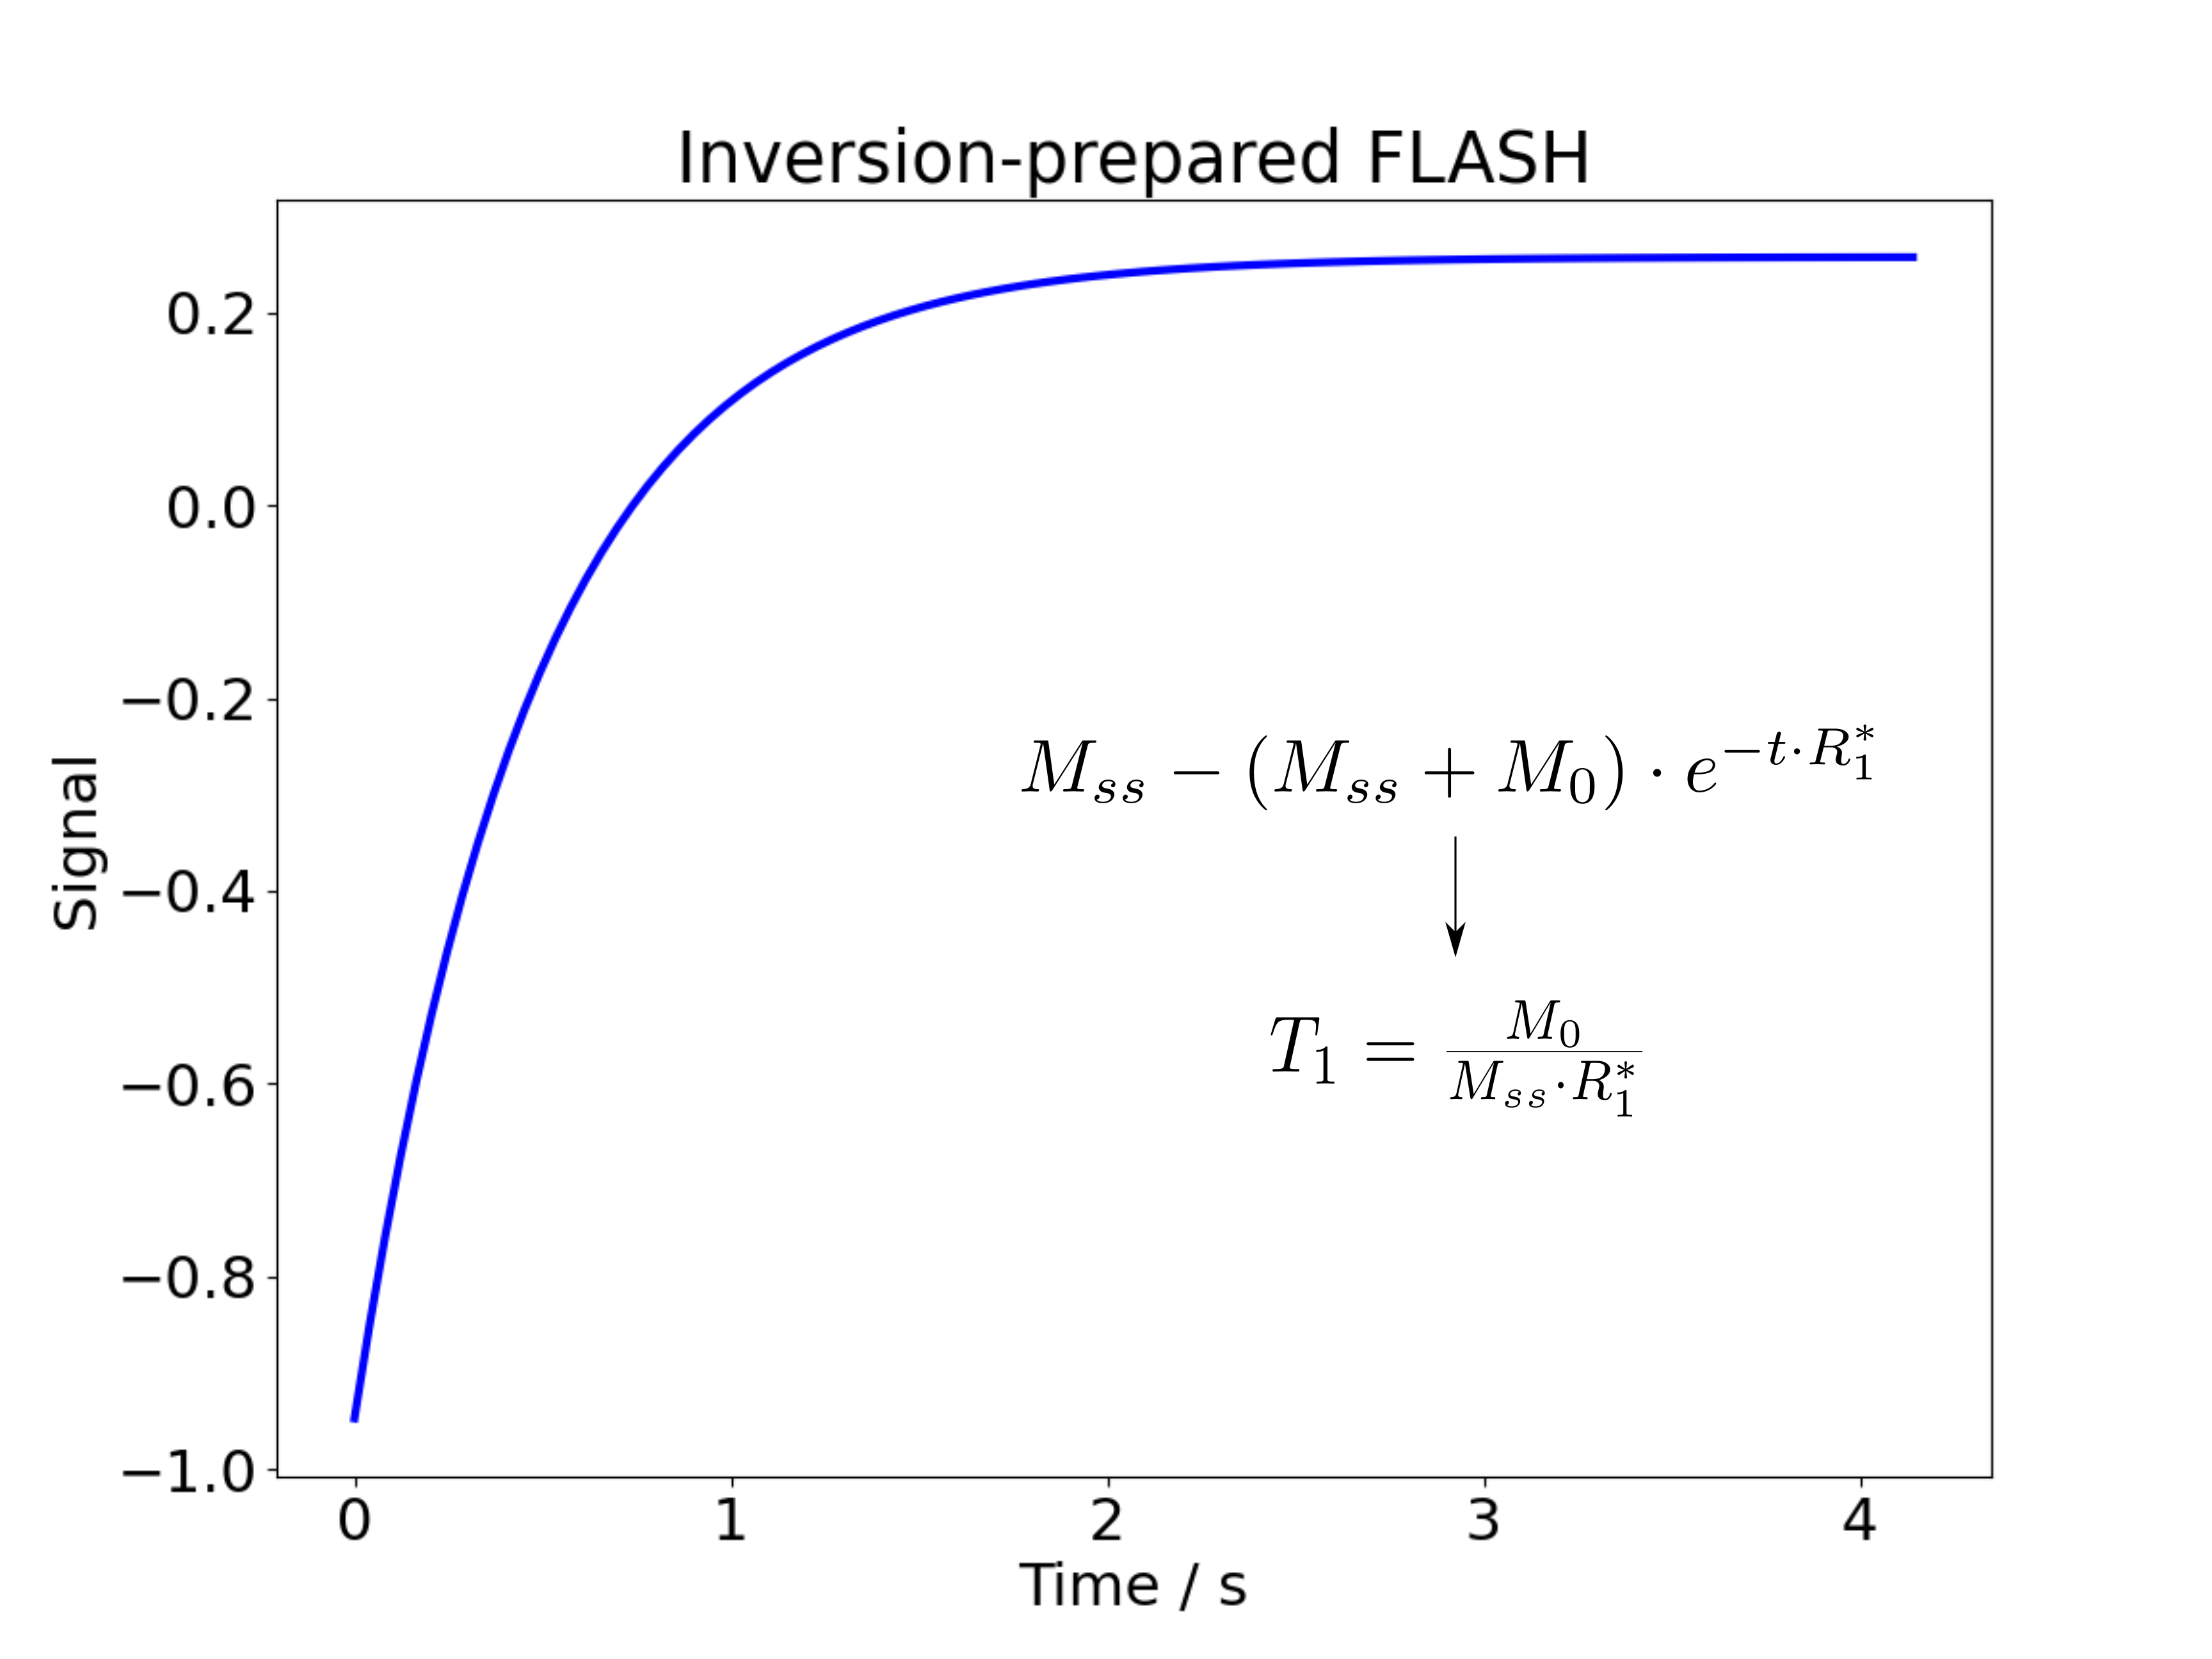

In [2]:
from IPython.display import Image
Image("IR_FLASH.png", width=600, height=600)

* General idea: Formulating the estimation of MR physical parameters directly from k-space as a nonlinear inverse problem

#### 1.2 Operator chain of parallel imaging and signal model (nonlinear)

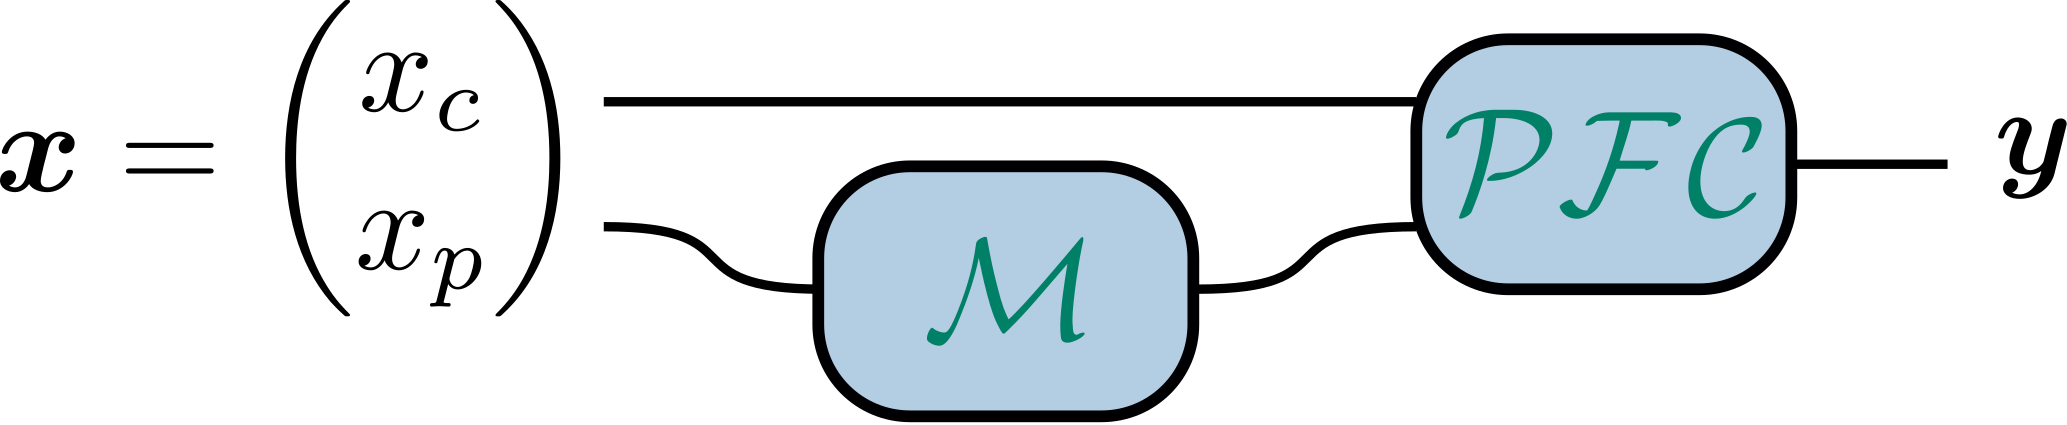

In [3]:
Image("operator_chain.png", width=350, height=350)

$$F: x \mapsto y = {\mathcal{P} \mathcal{F} C} \cdot {M(x)}$$
- $\mathcal{P}$ - sampling pattern
- $\mathcal{F}$ - Fourier transform
- $C$ - coil sensitivity maps
- $M(\cdot)$ - MR physics model
- $x$ - MR parameters
- $y$ - acquired kspace data

#### 1.3 Optimization

$$\hat{x} = \text{argmin}_{x}\|F(x) -y\|_{2}^{2} + \lambda \cdot R(x) $$

- We can use the iteratively regularized Gauss-Newton method (IRGNM) in BART to solve the above nonlinear inverse problem, i.e., the nonlinear problem can be linearly solved in each Gauss-Newton step,

$$\hat{x}_{n+1}= \text{argmin}_{x}\|DF(x_{n})(x−x_{n}) +F(x_{n})−y\|_{2}^{2} + \lambda \cdot R(x)$$

- $DF(x_{n})$ the Jacobian matrix of $F$ at the point $x_{n}$ of the $n$th Newton step
- Direct estimation of MR parameter maps (No fitting is needed)

Reference: Wang X, Roeloffs V, Klosowski J, Tan Z, Voit D, Uecker M, Frahm J. [Model-based T1 Mapping with Sparsity Constraints Using Single-Shot Inversion-Recovery Radial FLASH](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26726). Magnetic Resonance in Medicine 79:730-740 (2018) 

#### 1.4 BART Commands

In [5]:
%%bash

#### moba now supports T1, T2, water-fat and T2* mapping
bart moba -h

Usage: moba [-r ...] [-L ...] [-F ...] [-G ...] [-m d] [-l d] [-i d] [-R f] [-T f] [-j f] [-u f] [-C d] [-s f] [-B f] [-b ...] [-d d] [-f f] [-p <string>] [-J] [-M] [-g] [-I <string>] [-t <string>] [-o f] [-k] [--kfilter-1 ...] [--kfilter-2 ...] [-n] [--fat_spec_0 ...] <kspace> <TI/TE> <output> [<sensitivities>]

Model-based nonlinear inverse reconstruction


-r <T>:A:B:C	generalized regularization options (-rh for help)
-L		T1 mapping using model-based look-locker
-F		T2 mapping using model-based Fast Spin Echo
-G		T2* mapping using model-based multiple gradient echo
-m model      	Select the MGRE model from enum { WF = 0, WFR2S, WF2R2S, R2S, PHASEDIFF } [default: WFR2S]
-l reg      	1/-l2	toggle l1-wavelet or l2 regularization.
-i iter      	Number of Newton steps
-R redu      	reduction factor
-T damp      	damping on temporal frames
-j minreg      	Minimum regu. parameter
-u rho      	ADMM rho [default: 0.01]
-C iter      	inner iterations
-s step      	step size
-B bound      	low

### 2. Data Preparation 
#### The same as BART webinar 3 (https://github.com/mrirecon/bart-webinars/tree/master/webinar3).

2.1 Download raw data

2.2 Coil compression

2.3 Prepare radial trajectory (golden-angle) including gradient-delay correction

2.4 Prepare time vector

In [6]:
%%bash

## Download raw data
wget -q https://zenodo.org/record/4060287/files/IR-FLASH.cfl
wget -q https://zenodo.org/record/4060287/files/IR-FLASH.hdr

head -n2 IR-FLASH.hdr

# Dimensions
512 1 1 16 1 1 1 1 1 1 1020 1 1 1 1 1 


In [7]:
%%bash

## Coil compression
bart transpose 0 1 IR-FLASH ksp

# number of virtual coils
NUM_VCOILS=4 # for the purpose of fast computation
# coil compression
bart cc -A -p $NUM_VCOILS ksp ksp_cc

Done.


In [8]:
%%bash

# Assign dimensions to variables
READ=`bart show -d 0 IR-FLASH`
SPOKES=`bart show -d 2 IR-FLASH`
COILS=`bart show -d 3 IR-FLASH`
TIME=`bart show -d 10 IR-FLASH`
BR=$((READ/2))

## Prepare radial trajectory (golden-angle)
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$TIME traj

# Gradient Delay Correction
# Extract the steady-state data (data with less contrast change)
bart extract 10 920 1020 traj traj_extract
bart extract 10 920 1020 ksp_cc ksp_extract

# Transpose the 2nd and 10th dimension for the `estdelay` tool
bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

# Gradient delay estimation usign RING
GDELAY=$(bart estdelay -R traj_extract1 ksp_extract1)

echo "Gradient Delays: "$GDELAY

# Calculate the "correct" trajectory with known gradient delays
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$TIME -q $GDELAY trajn

Gradient Delays: -0.120232:0.163876:0.009013


In [9]:
%%bash

## Prepare time vector
TR=4100 #TR in [us]
BIN_SPOKES=20 # Bin data to save computational time 
TIME=`bart show -d 10 IR-FLASH`
NTIME=$((TIME/BIN_SPOKES))

# Create vector from 0 to NTIME
bart index 5 $NTIME tmp1
# use local index from newer bart with older bart
bart scale $(($BIN_SPOKES * $TR)) tmp1 tmp2
bart ones 6 1 1 1 1 1 $NTIME tmp1 
bart saxpy $((($BIN_SPOKES / 2) * $TR)) tmp1 tmp2 tmp3
bart scale 0.000001 tmp3 TI

# Reshape trajectory and data for model-based reconstruction
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 trajn traj_moba
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 ksp_cc ksp_cc_moba

# Resize data and trajectory for faster computation
bart resize -c 1 384 traj_moba traj_moba1
bart resize -c 1 384 ksp_cc_moba ksp_cc_moba1

echo "Trajectory:"
head -n2 traj_moba1.hdr

echo "Data:"
head -n2 ksp_cc_moba1.hdr

echo "TI:"
head -n2 TI.hdr

Trajectory:
# Dimensions
3 384 20 1 1 51 1 1 1 1 1 1 1 1 1 1 
Data:
# Dimensions
1 384 20 4 1 51 1 1 1 1 1 1 1 1 1 1 
TI:
# Dimensions
1 1 1 1 1 51 1 1 1 1 1 1 1 1 1 1 


### 3. Nonlinear Model-based Reconstruction
3.1 Model-based reconstruction

3.2 Visualize results

In [12]:
%%bash

# inversion-recovery Look-Locker T1 mapping
ITER=8 # number of Newton-steps
lambda=0.09 # regularitation parameter

bart moba -L -d4 -l1 -i8 -j0.09 -B0.0 -n -t traj_moba1 ksp_cc_moba1 TI reco_moba 

#-L  --- to select look-locker model
#-l1 --- to use l1-Wavelet regularization
#-i  --- number of Newton-steps
#-j  --- minimum regu. parameter
#-B  --- lower bound for relaxivity (R1s > 0)

# Note: There is no need of input of coil sensitivity maps, because we jointly estimate coils using model-based reconstruction

Process is terminated.


Writing 1 image(s)...done.


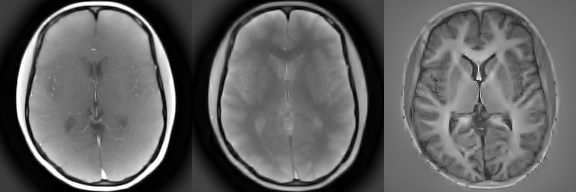

In [78]:
## Resize and Display the reconstructed maps, i.e., (Mss. M0, R1*)
!bart resize -c 0 192 1 192 reco_moba reco_maps
!bart resize -c 0 192 1 192 reco_moba reco_maps
!bart slice 6 0 reco_maps Mss
!bart slice 6 1 reco_maps M0
!bart slice 6 2 reco_maps R1s

!bart join 1 Mss M0 R1s tmp
!bart flip $(bart bitmask 0) tmp maps_all

!bart toimg -W maps_all maps_all.png
Image("maps_all.png", width=1000, height=1000)

Finally, from the above parameters, we can calculate and visualize the estimated T1 map.

/usr/lib/python3/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


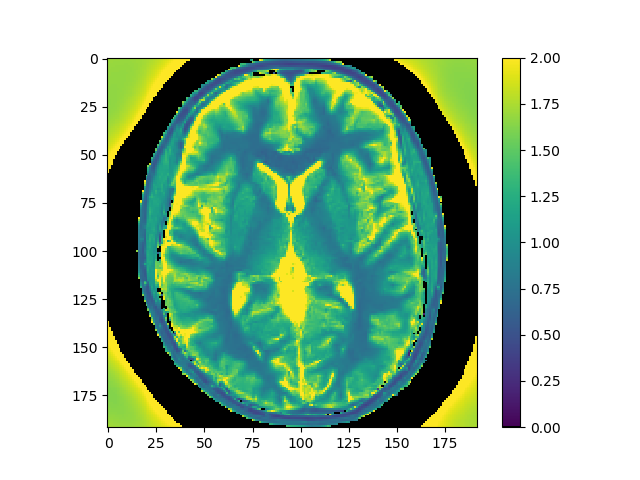

In [105]:
## use the "looklocker" tool in BART for post-processing
!bart looklocker -t0.2 -D15.3e-3 reco_maps tmp
!bart flip $(bart bitmask 0) tmp moba_T1map
!python3 save_maps.py moba_T1map viridis 0 2.0 moba_T1map.png
Image("moba_T1map.png", width=600, height=600)

Thank you for joining! Feel free to ask any questions:)